In [2]:
# 1-------------------------------
# Import necessary libraries
# -------------------------------
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import box_iou
from PIL import Image

# -------------------------------
# Set device (Kaggle P100 GPU)
# -------------------------------
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3080
Using device: cuda


In [3]:
# Utility: count classes from COCO and YOLO, and set num_classes
from pathlib import Path

def count_classes(dataset_root):
    ann_path = os.path.join(dataset_root, 'train', 'train_annotations.json')
    classes_from_coco = []
    if os.path.exists(ann_path):
        with open(ann_path, 'r', encoding='utf-8') as f:
            coco = json.load(f)
        classes_from_coco = [c.get('name', str(c.get('id'))) for c in coco.get('categories', [])]
    labels_dir = os.path.join(dataset_root, 'All labels with Pose information', 'labels')
    class_ids = set()
    if os.path.isdir(labels_dir):
        for p in Path(labels_dir).glob('*.txt'):
            for line in open(p, 'r', encoding='utf-8'):
                parts = line.strip().split()
                if parts:
                    try:
                        class_ids.add(int(parts[0]))
                    except Exception:
                        pass
    # Prefer COCO categories if present, else YOLO ids
    if classes_from_coco:
        cls_names = classes_from_coco
        n_no_bg = len(classes_from_coco)
    else:
        cls_names = [f'class_{i}' for i in sorted(class_ids)]
        n_no_bg = len(class_ids)
    n_with_bg = n_no_bg + 1  # add background for Faster R-CNN
    print('COCO categories:', cls_names)
    print('num_classes (without background):', n_no_bg)
    print('Faster R-CNN num_classes (with background):', n_with_bg)
    return cls_names, n_no_bg, n_with_bg

DATASET_ROOT = './C2A_Dataset/new_dataset3'
CLASS_NAMES, NUM_CLASSES_NO_BG, NUM_CLASSES = count_classes(DATASET_ROOT)

COCO categories: ['0']
num_classes (without background): 1
Faster R-CNN num_classes (with background): 2


In [4]:
# 2-------------------------------
# Custom Dataset Class (using COCO annotations)
# -------------------------------

def load_yolo_annotations(yolo_label_path, img_width, img_height):
    """
    Load YOLO-format annotations with pose information from a text file.
    
    Each line in the file has 6 values:
      - class: (ignored, because we are forcing a single "person" label)
      - x_center: normalized center x-coordinate of the bounding box
      - y_center: normalized center y-coordinate of the bounding box
      - width: normalized width of the bounding box
      - height: normalized height of the bounding box
      - pose: pose information (ignored in this version since we force the label to 1)
      
    The normalized coordinates are multiplied by the image width/height
    to convert them into absolute pixel values.
    
    The YOLO format defines bounding boxes with a center and dimensions.
    This function converts that format to the [x_min, y_min, x_max, y_max] format 
    required by Faster R-CNN.
    
    Returns:
       - boxes: a tensor of shape (N, 4) containing bounding boxes in absolute pixel coordinates.
       - labels: a tensor of shape (N,) containing the forced label (1) for "person".
    """
    
    # Check if the annotation file exists; if not, list available files for debugging.
    if not os.path.exists(yolo_label_path):
        available = os.listdir(os.path.dirname(yolo_label_path))
        raise FileNotFoundError(f"File not found: {yolo_label_path}\nAvailable files: {available}")

    boxes = []   # List to hold bounding box coordinates
    labels = []  # List to hold labels for each bounding box
    with open(yolo_label_path, 'r') as f:
        # Read each line in the YOLO annotation file.
        for line in f.readlines():
            # Split the line into separate values (as strings)
            values = line.strip().split()
            # Ensure that there are at least 6 values; if not, skip this line.
            if len(values) < 6:
                continue  # Skip invalid lines

            # Convert the relevant values from string to float:
            # Skip the first value (class) because we force the label later.
            # Extract normalized values
            x_center_norm, y_center_norm, width_norm, height_norm = map(float, values[1:5])

            # Convert normalized coordinates to absolute pixel values
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width_abs = width_norm * img_width
            height_abs = height_norm * img_height
            
            # Convert YOLO bounding box format (center, width, height) to
            # [x_min, y_min, x_max, y_max] format.
            # Convert YOLO bbox (center, width, height) to [x_min, y_min, x_max, y_max]
            x_min = x_center - (width_abs / 2)
            y_min = y_center - (height_abs / 2)
            x_max = x_center + (width_abs / 2)
            y_max = y_center + (height_abs / 2)

            # Append the converted bounding box to the list.
            boxes.append([x_min, y_min, x_max, y_max])

            # Assign label 1 for "person" (single-class human detection)
            person_label = 1
            labels.append(person_label)

    # Convert the lists of boxes and labels into torch tensors.
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

class C2ACocoDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Path to the new_dataset3 directory.
            split (str): 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir  # Root directory of the dataset
        self.split = split  # Dataset split (train/val/test)
        self.transform = transform  # Image transformations (e.g., normalization)

        # Image directory and COCO annotation JSON for the given split.
        # Define the image directory based on the split.
        self.img_dir = os.path.join(root_dir, split, "images")
        # Define the path to the COCO annotation JSON file for this split.
        self.ann_path = os.path.join(root_dir, split, f"{split}_annotations.json")

        # Load COCO JSON annotations.
        with open(self.ann_path, 'r') as f:
            self.coco_data = json.load(f)

        # Build mapping from image id to image info. (e.g., dimensions, filename).
        self.imgs = {img_info['id']: img_info for img_info in self.coco_data['images']}
        # Create a list of image IDs for indexing.
        self.ids = list(self.imgs.keys())

        # Define the folder that contains the YOLO-format labels with pose information.
        # This folder is inside the "All labels with Pose information" folder.
        self.pose_labels_dir = os.path.join(root_dir, "All labels with Pose information", "labels")

    def __len__(self):
        # Return the number of images in the dataset.
        return len(self.ids)

    def __getitem__(self, idx):
        """
        Retrieve a single image and its annotations.
        """
        # Retrieve image info.
        # Get the image ID from the list of IDs.
        img_id = self.ids[idx]
        # Retrieve the image information (dimensions, filename, etc.) using the image ID.
        img_info = self.imgs[img_id]
        # Extract the filename of the image.
        img_filename = img_info['file_name']
        # Build the full path to the image file.
        img_path = os.path.join(self.img_dir, img_filename)

        # Open the image using PIL and convert it to RGB format.
        image = Image.open(img_path).convert("RGB")
        # Apply transformations (e.g., ToTensor, normalization) if provided.
        if self.transform:
            image = self.transform(image)

        # Get image dimensions from COCO JSON.
        img_width = img_info['width']
        img_height = img_info['height']

        # Construct the path to the corresponding YOLO-format label file.
        # The label file has the same base filename as the image, but with a .txt extension.
        pose_label_path = os.path.join(self.pose_labels_dir, os.path.splitext(img_filename)[0] + ".txt")

        # Load YOLO annotations (with pose info) and convert to absolute coordinates.
        boxes, labels = load_yolo_annotations(pose_label_path, img_width, img_height)

        # Build the target dictionary expected by the detection model.
        target = {
            "boxes": boxes,             # Bounding boxes in [x_min, y_min, x_max, y_max] format.
            "labels": labels,           # Labels for each bounding box (forced to 1 for person).
            "image_id": torch.tensor([img_id])  # Unique image identifier.
        }
        return image, target

In [6]:
# Augmentations: on-the-fly with bbox-aware affine and HSV
import albumentations as A
import cv2

dataset_root = './C2A_Dataset/new_dataset3'

# ImageNet normalization to keep consistency with downstream visualization
from torchvision import transforms as T
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# YOLO-style augmentation params mapped to Albumentations
# hsv_h:0.015, hsv_s:0.7, hsv_v:0.4 ~ Albumentations HueSaturationValue
train_tf = A.Compose([
    A.HueSaturationValue(hue_shift_limit=int(0.015*360), sat_shift_limit=int(0.7*255), val_shift_limit=int(0.4*255), p=0.9),
    A.HorizontalFlip(p=0.5),  # fliplr=0.5
    A.Affine(
        rotate=(15, 30),     # degrees 15–30
        translate_percent=(0.1, 0.1),
        scale=(1-0.5, 1+0.5),
        shear=(0.0, 0.0),
        fit_output=False,
        cval=(114, 114, 114),
        mode=cv2.BORDER_CONSTANT,
        p=0.9
    ),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], clip=True, min_visibility=0.0))

eval_tf = A.Compose([], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], clip=True))

# Wrap the existing dataset to add Albumentations
class AugmentedC2A(C2ACocoDataset):
    def __init__(self, *args, augment=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.augment = augment
    
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        # Convert PIL image to numpy
        img_np = np.array(image)
        boxes = target['boxes'].numpy().astype(np.float32)
        labels = target['labels'].numpy().astype(np.int64)
        # Albumentations expects list of bboxes + labels
        bboxes = boxes.tolist()
        class_labels = labels.tolist()
        tf = train_tf if self.augment else eval_tf
        if len(bboxes) > 0:
            transformed = tf(image=img_np, bboxes=bboxes, class_labels=class_labels)
        else:
            transformed = tf(image=img_np, bboxes=[], class_labels=[])
        img_aug = transformed['image']
        bboxes_aug = transformed.get('bboxes', [])
        labels_aug = transformed.get('class_labels', [])
        # Clamp bboxes to image bounds and filter invalid/tiny
        if len(bboxes_aug) > 0:
            h, w = img_aug.shape[:2]
            b = np.asarray(bboxes_aug, dtype=np.float32)
            b[:,0] = np.clip(b[:,0], 0, w-1)
            b[:,1] = np.clip(b[:,1], 0, h-1)
            b[:,2] = np.clip(b[:,2], 0, w-1)
            b[:,3] = np.clip(b[:,3], 0, h-1)
            x1 = np.minimum(b[:,0], b[:,2]); y1 = np.minimum(b[:,1], b[:,3])
            x2 = np.maximum(b[:,0], b[:,2]); y2 = np.maximum(b[:,1], b[:,3])
            b = np.stack([x1,y1,x2,y2], axis=1)
            ws = (b[:,2]-b[:,0]); hs=(b[:,3]-b[:,1])
            keep = (ws>=2) & (hs>=2)
            b = b[keep]
            labels_aug = [l for l,k in zip(labels_aug, keep) if k]
        else:
            b = np.zeros((0,4), dtype=np.float32)
            labels_aug = []
        # Back to tensors + normalize
        image_t = T.ToTensor()(Image.fromarray(img_aug))
        image_t = normalize(image_t)
        target = {
            'boxes': torch.tensor(b, dtype=torch.float32),
            'labels': torch.tensor(labels_aug, dtype=torch.int64),
            'image_id': target['image_id']
        }
        return image_t, target

# Dataloaders with collate
collate_fn = lambda x: tuple(zip(*x))
train_dataset = AugmentedC2A(root_dir=DATASET_ROOT, split='train', transform=None, augment=True)
val_dataset   = AugmentedC2A(root_dir=DATASET_ROOT, split='val',   transform=None, augment=False)
test_dataset  = AugmentedC2A(root_dir=DATASET_ROOT, split='test',  transform=None, augment=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

print('Using AUGMENTED data loaders (with Albumentations + ImageNet normalization).')
image_example, target_example = train_dataset[0]
print("Sample target (plain pipeline check):", target_example)

C:\Users\PC\AppData\Local\Temp\ipykernel_33904\1120163548.py:16: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(


Using AUGMENTED data loaders (with Albumentations + ImageNet normalization).
Sample target (plain pipeline check): {'boxes': tensor([[238.9558, 365.2289, 252.0739, 374.8741],
        [ 84.0873, 371.1316, 110.9021, 388.8612],
        [  5.1228, 407.0016,  17.9928, 419.1950],
        [ 20.0405, 492.4006,  45.2060, 505.1938],
        [183.5082, 377.5670, 205.4555, 390.6006],
        [392.5344, 188.6778, 398.3096, 192.7999],
        [107.0360, 312.5906, 118.9164, 321.8223],
        [291.0250, 327.9426, 302.5755, 336.1869],
        [552.5179, 175.4117, 565.3060, 184.0695],
        [352.8196, 346.5429, 355.7898, 348.8509],
        [196.9789, 253.9745, 227.6730, 266.8606],
        [313.4055, 205.0708, 339.3957, 220.3324],
        [  0.0000, 321.9103,   2.9916, 332.7031],
        [184.4410, 236.2297, 205.8935, 247.7823],
        [435.9029, 360.0753, 440.9352, 365.2649],
        [436.8173, 309.6597, 467.8399, 330.1108],
        [ 19.1469, 411.4857,  46.9512, 432.1770],
        [251.5912, 302.57

In [6]:
# # 3-------------------------------
# # Define image transforms: conversion to tensor and ImageNet normalization
# # -------------------------------

# # This cell defined a plain (non-augmented) pipeline earlier. To avoid overriding the
# # augmented loaders, we keep these as separate *_plain variables. Use them only if needed.
# from torchvision import transforms

# transform_plain = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# from torch.utils.data import DataLoader

# train_dataset_plain = C2ACocoDataset(root_dir=dataset_root, split='train', transform=transform_plain)
# train_loader_plain = DataLoader(train_dataset_plain, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# val_dataset_plain = C2ACocoDataset(root_dir=dataset_root, split='val', transform=transform_plain)
# val_loader_plain = DataLoader(val_dataset_plain, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# test_dataset_plain = C2ACocoDataset(root_dir=dataset_root, split='test', transform=transform_plain)
# test_loader_plain = DataLoader(test_dataset_plain, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# # Keep a quick sample check without affecting the main augmented loaders
# _sample_ds = C2ACocoDataset(root_dir=dataset_root, split='train', transform=transform_plain)
# image, target = _sample_ds[0]
# print("Sample target (plain pipeline check):", target)
# print("NOTE: Main training/eval uses AUGMENTED loaders: train_loader / val_loader / test_loader.")

In [7]:
# 4-------------------------------
# Model Setup: Pretrained Faster R-CNN (MS COCO) + custom predictor
# -------------------------------
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Load MS COCO pretrained weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # MS COCO
model = fasterrcnn_resnet50_fpn(weights=weights)

# Replace the classifier head for our dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Move to device
model.to(device)

print("Loaded pretrained Faster R-CNN (MS COCO) and replaced predictor to num_classes=", NUM_CLASSES)

Loaded pretrained Faster R-CNN (MS COCO) and replaced predictor to num_classes= 2


In [8]:
# 5-------------------------------
# Training Loop (with best-model checkpoint) + progress bars
# -------------------------------
from tqdm import tqdm
from time import perf_counter

# (Re)define optimizer / scheduler only if not already defined
if 'optimizer' not in globals():
    optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0005)
if 'lr_scheduler' not in globals():
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
if 'num_epochs' not in globals():
    num_epochs = 25
if 'patience' not in globals():
    patience = 5  # early stopping patience
if 'best_val_loss' not in globals():
    best_val_loss = float('inf')
if 'epochs_no_improve' not in globals():
    epochs_no_improve = 0

ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

# Validation with progress bar (loss dict requires model in train mode)
def compute_val_loss(model, data_loader, device, max_batches=None):
    model.train()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for i, (images, targets) in enumerate(tqdm(data_loader, desc='Validating', leave=False)):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                loss = sum(loss for loss in loss_dict.values())
            else:
                raise TypeError('Expected loss_dict to be a dictionary.')
            total_loss += loss.item()
            count += 1
            if max_batches is not None and count >= max_batches:
                break
    model.eval()
    return total_loss / count if count > 0 else 0.0

print('Starting training with progress bars...')
for epoch in range(epoch if 'epoch' in globals() else 0, num_epochs):
    model.train()
    epoch_start = perf_counter()
    running_loss = 0.0
    batch_count = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:
            raise TypeError('Expected loss_dict to be a dictionary.')
        if torch.isnan(losses):
            pbar.write('Warning: NaN loss detected; skipping batch')
            continue
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        running_loss += losses.item()
        batch_count += 1
        if batch_count % 10 == 0:
            pbar.set_postfix({'loss': f'{running_loss / batch_count:.4f}'})

    val_loss = compute_val_loss(model, val_loader, device, max_batches=None)
    lr_scheduler.step()

    epoch_time = (perf_counter() - epoch_start) / 60
    print(f'Epoch {epoch+1}: train_loss={running_loss / max(1,batch_count):.4f} val_loss={val_loss:.4f} time={epoch_time:.2f} min')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        save_path = os.path.join(ckpt_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'num_classes': NUM_CLASSES
        }, save_path)
        print(f'Saved best model to {save_path}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

print('Training complete. Best val_loss:', best_val_loss)

Starting training with progress bars...


Epoch 1/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.41it/s, loss=1.3262]


Epoch 1: train_loss=1.3257 val_loss=1.3850 time=10.46 min
Saved best model to ./checkpoints\best_model.pth


Epoch 2/25: 100%|██████████| 6129/6129 [08:54<00:00, 11.48it/s, loss=1.1930]


Epoch 2: train_loss=1.1932 val_loss=1.2265 time=10.41 min
Saved best model to ./checkpoints\best_model.pth


Epoch 3/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.42it/s, loss=1.1487]


Epoch 3: train_loss=1.1488 val_loss=1.1650 time=10.47 min
Saved best model to ./checkpoints\best_model.pth


Epoch 4/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.42it/s, loss=1.0765]


Epoch 4: train_loss=1.0767 val_loss=1.0754 time=10.46 min
Saved best model to ./checkpoints\best_model.pth


Epoch 5/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.42it/s, loss=1.0609]


Epoch 5: train_loss=1.0608 val_loss=1.0076 time=10.46 min
Saved best model to ./checkpoints\best_model.pth


Epoch 6/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.43it/s, loss=1.0464]


Epoch 6: train_loss=1.0464 val_loss=1.0198 time=10.45 min


Epoch 7/25: 100%|██████████| 6129/6129 [08:55<00:00, 11.44it/s, loss=1.0146]


Epoch 7: train_loss=1.0146 val_loss=1.0278 time=10.45 min


Epoch 8/25: 100%|██████████| 6129/6129 [08:55<00:00, 11.44it/s, loss=1.0037]


Epoch 8: train_loss=1.0036 val_loss=0.9660 time=10.44 min
Saved best model to ./checkpoints\best_model.pth


Epoch 9/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.43it/s, loss=1.0018]


Epoch 9: train_loss=1.0018 val_loss=0.9418 time=10.46 min
Saved best model to ./checkpoints\best_model.pth


Epoch 10/25: 100%|██████████| 6129/6129 [08:53<00:00, 11.49it/s, loss=0.9795]


Epoch 10: train_loss=0.9797 val_loss=0.9245 time=10.39 min
Saved best model to ./checkpoints\best_model.pth


Epoch 11/25: 100%|██████████| 6129/6129 [08:56<00:00, 11.43it/s, loss=0.9765]


Epoch 11: train_loss=0.9766 val_loss=0.9263 time=10.45 min


Epoch 12/25: 100%|██████████| 6129/6129 [11:11<00:00,  9.12it/s, loss=0.9730]


Epoch 12: train_loss=0.9730 val_loss=0.9073 time=12.70 min
Saved best model to ./checkpoints\best_model.pth


Epoch 13/25: 100%|██████████| 6129/6129 [10:41<00:00,  9.55it/s, loss=0.9627]


Epoch 13: train_loss=0.9625 val_loss=0.9124 time=13.15 min


Epoch 14/25: 100%|██████████| 6129/6129 [12:31<00:00,  8.15it/s, loss=0.9607]


Epoch 14: train_loss=0.9607 val_loss=0.9036 time=14.31 min
Saved best model to ./checkpoints\best_model.pth


Epoch 15/25: 100%|██████████| 6129/6129 [12:49<00:00,  7.97it/s, loss=0.9545]


Epoch 15: train_loss=0.9546 val_loss=0.9035 time=15.18 min
Saved best model to ./checkpoints\best_model.pth


Epoch 16/25: 100%|██████████| 6129/6129 [12:36<00:00,  8.11it/s, loss=0.9489]


Epoch 16: train_loss=0.9490 val_loss=0.8935 time=14.95 min
Saved best model to ./checkpoints\best_model.pth


Epoch 17/25: 100%|██████████| 6129/6129 [12:37<00:00,  8.09it/s, loss=0.9502]


Epoch 17: train_loss=0.9503 val_loss=0.8958 time=15.12 min


Epoch 18/25: 100%|██████████| 6129/6129 [12:50<00:00,  7.96it/s, loss=0.9502]


Epoch 18: train_loss=0.9502 val_loss=0.8924 time=15.30 min
Saved best model to ./checkpoints\best_model.pth


Epoch 19/25: 100%|██████████| 6129/6129 [13:04<00:00,  7.81it/s, loss=0.9476]


Epoch 19: train_loss=0.9478 val_loss=0.8932 time=15.51 min


Epoch 20/25: 100%|██████████| 6129/6129 [10:36<00:00,  9.63it/s, loss=0.9439]


Epoch 20: train_loss=0.9439 val_loss=0.8903 time=12.11 min
Saved best model to ./checkpoints\best_model.pth


Epoch 21/25: 100%|██████████| 6129/6129 [08:49<00:00, 11.58it/s, loss=0.9430]


Epoch 21: train_loss=0.9432 val_loss=0.8879 time=10.32 min
Saved best model to ./checkpoints\best_model.pth


Epoch 22/25: 100%|██████████| 6129/6129 [08:49<00:00, 11.57it/s, loss=0.9420]


Epoch 22: train_loss=0.9421 val_loss=0.8914 time=10.32 min


Epoch 23/25: 100%|██████████| 6129/6129 [08:49<00:00, 11.57it/s, loss=0.9411]


Epoch 23: train_loss=0.9409 val_loss=0.8870 time=10.32 min
Saved best model to ./checkpoints\best_model.pth


Epoch 24/25: 100%|██████████| 6129/6129 [08:50<00:00, 11.55it/s, loss=0.9419]


Epoch 24: train_loss=0.9419 val_loss=0.8881 time=10.34 min


Epoch 25/25: 100%|██████████| 6129/6129 [08:49<00:00, 11.58it/s, loss=0.9429]
                                                               

Epoch 25: train_loss=0.9428 val_loss=0.8890 time=10.32 min
Training complete. Best val_loss: 0.8870183920749425


In [9]:
# Evaluation Function (with progress bars)
from tqdm import tqdm

def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.1, max_batches=None):
    """
    Evaluate the detection model using several metrics with a progress bar.

    Metrics:
      - Precision, Recall, F1
      - Average IoU (matched boxes)
      - Simplified mAP (0.5:0.95) and mAP@0.50 (very approximate)

    Args:
        model: detection model
        data_loader: DataLoader (batch_size assumed 1 for clarity)
        device: torch.device
        iou_threshold: IoU threshold for TP
        score_threshold: score threshold for filtering predictions
        max_batches: optionally limit evaluation batches (speed during debug)
    """
    model.eval()
    total_tp = total_fp = total_fn = 0
    total_iou = 0.0
    matched_boxes = 0
    aps = []
    iou_thresholds = [0.5 + i * 0.05 for i in range(10)]

    iterator = tqdm(data_loader, desc='Evaluating', leave=True)
    for b_idx, (images, targets) in enumerate(iterator):
        if max_batches is not None and b_idx >= max_batches:
            break
        image = images[0].to(device)
        target = {k: v.to(device) for k, v in targets[0].items()}
        with torch.no_grad():
            outputs = model([image])[0]
        pred_boxes = outputs['boxes'][outputs['scores'] > score_threshold]
        gt_boxes = target['boxes']

        if len(pred_boxes) == 0:
            total_fn += len(gt_boxes)
            iterator.set_postfix({'TP': total_tp, 'FP': total_fp, 'FN': total_fn})
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        used_gt = set()
        for i in range(len(pred_boxes)):
            if ious.shape[1] == 0:
                break
            max_iou, max_idx = ious[i].max(0)
            if max_iou >= iou_threshold and max_idx.item() not in used_gt:
                total_tp += 1
                total_iou += max_iou.item()
                matched_boxes += 1
                used_gt.add(max_idx.item())
            else:
                total_fp += 1
        total_fn += len(gt_boxes) - len(used_gt)

        # Simplified AP across thresholds
        for thr in iou_thresholds:
            tp_thr = fp_thr = 0
            fn_thr = len(gt_boxes)
            matched_gt_thr = set()
            for i in range(len(pred_boxes)):
                if ious.shape[1] == 0:
                    break
                max_iou, max_idx = ious[i].max(0)
                if max_iou >= thr and max_idx.item() not in matched_gt_thr:
                    tp_thr += 1
                    matched_gt_thr.add(max_idx.item())
                else:
                    fp_thr += 1
            fn_thr -= len(matched_gt_thr)
            precision_thr = tp_thr / (tp_thr + fp_thr) if (tp_thr + fp_thr) > 0 else 0
            recall_thr = tp_thr / (tp_thr + fn_thr) if (tp_thr + fn_thr) > 0 else 0
            ap = precision_thr * recall_thr  # coarse approximation
            aps.append(ap)

        iterator.set_postfix({
            'TP': total_tp,
            'FP': total_fp,
            'FN': total_fn,
            'avgIoU': (total_iou / matched_boxes) if matched_boxes > 0 else 0.0
        })

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = total_iou / matched_boxes if matched_boxes > 0 else 0
    mAP = sum(aps) / len(aps) if aps else 0
    mAP_50 = aps[0] if aps else 0

    print('\nEvaluation Metrics:')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f}')
    print(f'Avg IoU:   {avg_iou:.4f}')
    print(f'mAP:       {mAP:.4f}')
    print(f'mAP@0.50:  {mAP_50:.4f}')
    return precision, recall, f1_score, avg_iou, mAP, mAP_50

print('Running evaluation with progress bar on validation set:')
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, val_loader, device, score_threshold=0.1)
print('Running evaluation with progress bar on test set:')
precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, test_loader, device, score_threshold=0.1)

Running evaluation with progress bar on validation set:


Evaluating: 100%|██████████| 2043/2043 [03:20<00:00, 10.18it/s, TP=55681, FP=53027, FN=14183, avgIoU=0.779]



Evaluation Metrics:
Precision: 0.5122
Recall:    0.7970
F1 Score:  0.6236
Avg IoU:   0.7789
mAP:       0.2141
mAP@0.50:  0.2169
Running evaluation with progress bar on test set:


Evaluating: 100%|██████████| 2043/2043 [03:23<00:00, 10.05it/s, TP=56292, FP=52760, FN=13952, avgIoU=0.781]


Evaluation Metrics:
Precision: 0.5162
Recall:    0.8014
F1 Score:  0.6279
Avg IoU:   0.7807
mAP:       0.2178
mAP@0.50:  0.5472


In [10]:
# # 6-------------------------------
# # Evaluation Function
# # -------------------------------
# def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.1):
#     """
#     Evaluate the detection model using several metrics.
    
#     This function calculates:
#     - Precision: Proportion of predicted boxes that are correct.
#     - Recall: Proportion of ground truth boxes that were detected.
#     - F1 Score: Harmonic mean of precision and recall.
#     - Average IoU: Average Intersection over Union of matched predictions.
#     - mAP: Mean Average Precision over multiple IoU thresholds (0.5 to 0.95).
#     - mAP@0.50: Average Precision at a fixed IoU threshold of 0.50.
    
#     By default, the score_threshold is lowered to 0.1 to allow more low-confidence boxes to be considered,
#     which can help if the custom model produces lower scores than expected.
    
#     Args:
#         model: The detection model.
#         data_loader: DataLoader for the dataset to evaluate.
#         device: The device (GPU/CPU) to run evaluation on.
#         iou_threshold: The IoU threshold for considering a prediction as a true positive.
#         score_threshold: The score threshold for filtering predictions.
    
#     Returns:
#         Tuple with (precision, recall, f1_score, avg_iou, mAP, mAP_50)
#     """
#     model.eval()  # Set model to evaluation mode (disables dropout and updates batch norm stats)
    
#     # Initialize accumulators for overall true positives, false positives, false negatives, and IoU.
#     total_tp, total_fp, total_fn = 0, 0, 0
#     total_iou = 0.0
#     matched_boxes = 0  # Count of matched bounding boxes (true positives)
    
#     # List to store the computed AP (Average Precision) for a range of IoU thresholds.
#     aps = []
#     # Define IoU thresholds ranging from 0.5 to 0.95 (in 0.05 increments)
#     iou_thresholds = [0.5 + i * 0.05 for i in range(10)]
    
#     # Disable gradient computations since we are evaluating.
#     with torch.no_grad():
#         # Loop over the data loader (assuming each batch contains one image)
#         for images, targets in data_loader:
#             # Move the image to the device.
#             image = images[0].to(device)
#             # Move target annotations (e.g., bounding boxes and labels) to the device.
#             target = {k: v.to(device) for k, v in targets[0].items()}
            
#             # Run a forward pass on the model for the given image.
#             # During inference, we only pass the image (without target) to obtain predictions.
#             outputs = model([image])[0]
            
#             # Filter predictions using the score threshold.
#             # Lowering score_threshold from 0.5 (default) to 0.1 allows more predictions to be considered.
#             pred_boxes = outputs['boxes'][outputs['scores'] > score_threshold]
#             # Ground truth bounding boxes for the image.
#             gt_boxes = target['boxes']
            
#             # If no predictions pass the threshold, treat all ground truth boxes as false negatives.
#             if len(pred_boxes) == 0:
#                 total_fn += len(gt_boxes)
#                 continue
            
#             # Compute Intersection-over-Union (IoU) between each predicted box and the ground truth boxes.
#             ious = box_iou(pred_boxes, gt_boxes)
#             used_gt = set()  # To mark which ground truth boxes have already been matched
            
#             # Iterate over each predicted bounding box.
#             for i in range(len(pred_boxes)):
#                 # If no ground truth boxes exist, skip.
#                 if ious.shape[1] == 0:
#                     continue
#                 # For the i-th prediction, get the maximum IoU value and the corresponding ground truth index.
#                 max_iou, max_idx = ious[i].max(0)
#                 # Check if the maximum IoU meets the specified iou_threshold and that the matching gt hasn't been used.
#                 if max_iou >= iou_threshold and max_idx.item() not in used_gt:
#                     total_tp += 1  # Count as a true positive.
#                     total_iou += max_iou.item()  # Accumulate IoU for averaging later.
#                     matched_boxes += 1  # Count the matched box.
#                     used_gt.add(max_idx.item())  # Mark this ground truth box as used.
#                 else:
#                     total_fp += 1  # If not, count as a false positive.
#             # Any remaining ground truth boxes that were not matched are false negatives.
#             total_fn += len(gt_boxes) - len(used_gt)
            
#             # Now, compute a simplified Average Precision (AP) at multiple IoU thresholds.
#             for threshold in iou_thresholds:
#                 tp, fp, fn = 0, 0, len(gt_boxes)
#                 matched_gt = set()
#                 # Evaluate each prediction at the current IoU threshold.
#                 for i in range(len(pred_boxes)):
#                     if ious.shape[1] == 0:
#                         continue
#                     max_iou, max_idx = ious[i].max(0)
#                     if max_iou >= threshold and max_idx.item() not in matched_gt:
#                         tp += 1  # True Positive for this threshold.
#                         matched_gt.add(max_idx.item())
#                     else:
#                         fp += 1  # False Positive for this threshold.
#                 fn -= len(matched_gt)
#                 precision_thresh = tp / (tp + fp) if (tp + fp) > 0 else 0
#                 recall_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0
#                 ap = precision_thresh * recall_thresh  # A simplified estimation of AP.
#                 aps.append(ap)
    
#     # Calculate overall metrics across all images in the dataset.
#     precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
#     recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
#     f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
#     avg_iou = total_iou / matched_boxes if matched_boxes > 0 else 0
    
#     # Compute mean Average Precision (mAP) as the average of the AP values across all IoU thresholds.
#     mAP = sum(aps) / len(aps) if aps else 0  
#     # mAP@0.5 is the AP at IoU threshold 0.5 (first value in the iou_thresholds list).
#     mAP_50 = aps[0] if aps else 0  
    
#     # Print the computed evaluation metrics.
#     print("Testing Metrics:")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1 Score:  {f1_score:.4f}")
#     print(f"Avg IoU:   {avg_iou:.4f}")
#     print(f"mAP:       {mAP:.4f}")
#     print(f"mAP@.50:   {mAP_50:.4f}")
    
#     # Return all metrics for further use if needed.
#     return precision, recall, f1_score, avg_iou, mAP, mAP_50

# # -------------------------------
# # Compute evaluation metrics on the validation set.
# # -------------------------------
# print("Testing Metrics on the validation set:")
# precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, val_loader, device, score_threshold=0.1)

# # -------------------------------
# # Evaluate on the test set now instead of the validation set.
# # -------------------------------
# print("Testing Metrics on the test set:")
# precision, recall, f1, avg_iou, mAP, mAP_50 = evaluate_model(model, test_loader, device, score_threshold=0.1)


Loaded best model from ./checkpoints\best_model.pth (epoch=23, val_loss=0.8870)
Evaluating (val/test) for graphs...


Evaluating: 100%|██████████| 2043/2043 [03:16<00:00, 10.39it/s, TP=55681, FP=53027, FN=14183, avgIoU=0.779]



Evaluation Metrics:
Precision: 0.5122
Recall:    0.7970
F1 Score:  0.6236
Avg IoU:   0.7789
mAP:       0.2141
mAP@0.50:  0.2169


Evaluating: 100%|██████████| 2043/2043 [03:18<00:00, 10.31it/s, TP=56292, FP=52760, FN=13952, avgIoU=0.781]



Evaluation Metrics:
Precision: 0.5162
Recall:    0.8014
F1 Score:  0.6279
Avg IoU:   0.7807
mAP:       0.2178
mAP@0.50:  0.5472



Summary:
{'val': {'loss': 0.8871469674627395, 'precision': 0.512207013283291, 'recall': 0.7969912973777625, 'f1': 0.6236252043993459, 'avg_iou': 0.778877617794473, 'mAP': 0.21406955961798416, 'mAP@0.50': 0.21694480102695765, 'mse': 2.436375617980957, 'mae': 0.8378005623817444, 'r2': 0.999929435343061, 'matches': 55681}, 'test': {'loss': 0.8834297087078169, 'precision': 0.5161941092322928, 'recall': 0.8013780536415922, 'f1': 0.6279225414956273, 'avg_iou': 0.7806622470082958, 'mAP': 0.21779132225387712, 'mAP@0.50': 0.5471956224350205, 'mse': 2.404054641723633, 'mae': 0.8275155425071716, 'r2': 0.9999354163265218, 'matches': 56292}}


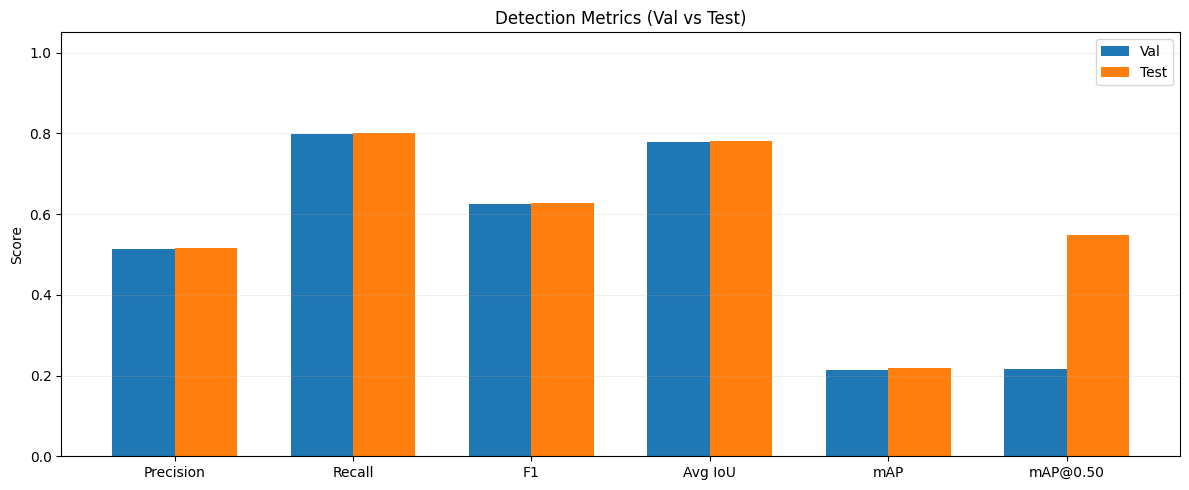

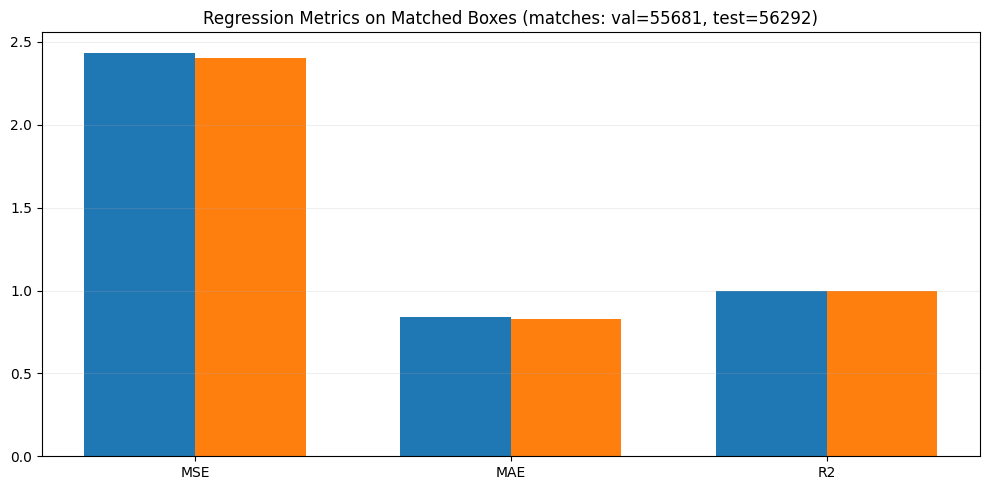

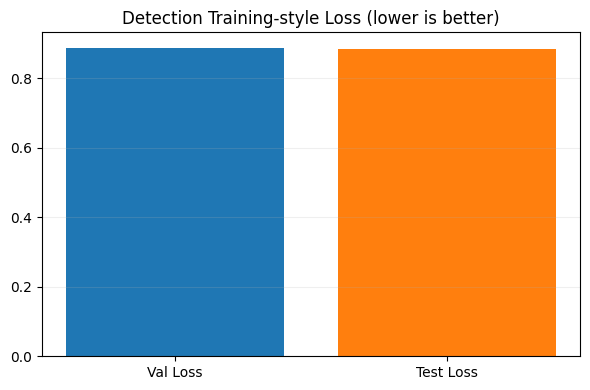


หมายเหตุ:
- โค้ดนี้สามารถรันได้เลยโดยไม่ต้องเทรนใหม่ ถ้ามีไฟล์ checkpoints/best_model.pth จะโหลดให้อัตโนมัติ
- Accuracy ในงานตรวจจับวัตถุไม่ได้ใช้แบบคลาสสิค จึงแสดง Precision/Recall/F1 แทน
- R2/MAE/MSE คำนวณจากความคลาดเคลื่อนระหว่างกรอบคาดการณ์กับกรอบจริงเฉพาะคู่ที่จับคู่กันได้ (IoU≥0.5)


In [10]:
# Performance Graphs from evaluation metrics
# This cell loads the best checkpoint (if available), evaluates on val/test,
# computes Loss, Precision/Recall/F1/IoU/mAP, and regression-style metrics (MSE/MAE/R2) on matched boxes,
# then plots side-by-side graphs.

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.ops import box_iou

# 1) Load best model if available (no retrain needed)
ckpt_path = os.path.join('./checkpoints', 'best_model.pth')
if os.path.exists(ckpt_path):
    try:
        checkpoint = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from {ckpt_path} (epoch={checkpoint.get('epoch')}, val_loss={checkpoint.get('val_loss'):.4f})")
    except Exception as e:
        print(f"Found checkpoint but failed to load: {e}. Using current in-memory model.")
else:
    print("No best checkpoint found. Using current in-memory model.")

model.eval()

# 2) Helpers to compute dataset loss and regression metrics over matched boxes

def dataset_loss(model, loader, device, max_batches=None):
    """Compute average training-style loss over a loader (requires targets)."""
    was_training = model.training
    model.train()
    total, n = 0.0, 0
    with torch.no_grad():
        for b_idx, (images, targets) in enumerate(tqdm(loader, desc='Computing loss', leave=False)):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            if not isinstance(loss_dict, dict):
                raise TypeError('Expected detection model to return a dict of losses in train mode')
            loss_val = sum(loss for loss in loss_dict.values()).item()
            total += loss_val
            n += 1
            if max_batches is not None and n >= max_batches:
                break
    model.train(was_training)
    return (total / max(1, n))


def bbox_regression_metrics(model, loader, device, iou_threshold=0.5, score_threshold=0.1, max_batches=None):
    """
    Compute MSE/MAE/R2 over matched predicted vs GT boxes across the dataset.
    Matching uses greedy max IoU with IoU >= iou_threshold.
    Returns dict with mse, mae, r2, matches, samples.
    """
    y_true_list, y_pred_list = [], []
    samples = 0
    with torch.no_grad():
        for b_idx, (images, targets) in enumerate(tqdm(loader, desc='Collecting box errors', leave=False)):
            image = images[0].to(device)
            target = {k: v.to(device) for k, v in targets[0].items()}
            outputs = model([image])[0]
            keep = outputs['scores'] > score_threshold
            pred_boxes = outputs['boxes'][keep]
            gt_boxes = target['boxes']

            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)
                used_gt = set()
                for i in range(len(pred_boxes)):
                    if ious.shape[1] == 0:
                        break
                    max_iou, max_idx = ious[i].max(0)
                    if max_iou >= iou_threshold and max_idx.item() not in used_gt:
                        y_pred_list.append(pred_boxes[i].detach().cpu().numpy())
                        y_true_list.append(gt_boxes[max_idx.item()].detach().cpu().numpy())
                        used_gt.add(max_idx.item())
            samples += 1
            if max_batches is not None and b_idx + 1 >= max_batches:
                break

    if len(y_true_list) == 0:
        return {
            'mse': float('nan'),
            'mae': float('nan'),
            'r2': float('nan'),
            'matches': 0,
            'samples': samples
        }

    y_true = np.stack(y_true_list, axis=0)  # [M,4]
    y_pred = np.stack(y_pred_list, axis=0)  # [M,4]
    diff = y_pred - y_true
    mse = float(np.mean(diff**2))
    mae = float(np.mean(np.abs(diff)))

    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ss_res = float(np.sum((yt - yp) ** 2))
    ss_tot = float(np.sum((yt - yt.mean()) ** 2)) + 1e-9
    r2 = 1.0 - ss_res / ss_tot

    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'matches': y_true.shape[0],
        'samples': samples
    }

# 3) Run evaluation to get classification-style metrics (from Cell 8) and our regression metrics
print('Evaluating (val/test) for graphs...')
val_precision, val_recall, val_f1, val_avg_iou, val_mAP, val_mAP50 = evaluate_model(model, val_loader, device, score_threshold=0.1)
test_precision, test_recall, test_f1, test_avg_iou, test_mAP, test_mAP50 = evaluate_model(model, test_loader, device, score_threshold=0.1)

# Compute loss per split (optional but requested for graph)
val_loss = dataset_loss(model, val_loader, device)
test_loss = dataset_loss(model, test_loader, device)

# Compute regression metrics on matched boxes
val_reg = bbox_regression_metrics(model, val_loader, device)
test_reg = bbox_regression_metrics(model, test_loader, device)

print('\nSummary:')
print({
    'val': {
        'loss': val_loss,
        'precision': val_precision,
        'recall': val_recall,
        'f1': val_f1,
        'avg_iou': val_avg_iou,
        'mAP': val_mAP,
        'mAP@0.50': val_mAP50,
        'mse': val_reg['mse'],
        'mae': val_reg['mae'],
        'r2': val_reg['r2'],
        'matches': val_reg['matches']
    },
    'test': {
        'loss': test_loss,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'avg_iou': test_avg_iou,
        'mAP': test_mAP,
        'mAP@0.50': test_mAP50,
        'mse': test_reg['mse'],
        'mae': test_reg['mae'],
        'r2': test_reg['r2'],
        'matches': test_reg['matches']
    }
})

# 4) Plot graphs
# 4.1 Classification-style metrics
metrics_names = ['Precision', 'Recall', 'F1', 'Avg IoU', 'mAP', 'mAP@0.50']
val_values = [val_precision, val_recall, val_f1, val_avg_iou, val_mAP, val_mAP50]
test_values = [test_precision, test_recall, test_f1, test_avg_iou, test_mAP, test_mAP50]

x = np.arange(len(metrics_names))
width = 0.35
plt.figure(figsize=(12,5))
plt.bar(x - width/2, val_values, width, label='Val')
plt.bar(x + width/2, test_values, width, label='Test')
plt.xticks(x, metrics_names, rotation=0)
plt.ylabel('Score')
plt.title('Detection Metrics (Val vs Test)')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

# 4.2 Regression-style metrics on matched boxes (lower is better for MSE/MAE)
reg_names = ['MSE', 'MAE', 'R2']
val_reg_values = [val_reg['mse'], val_reg['mae'], val_reg['r2']]
test_reg_values = [test_reg['mse'], test_reg['mae'], test_reg['r2']]

x = np.arange(len(reg_names))
plt.figure(figsize=(10,5))
plt.bar(x - width/2, val_reg_values, width, label='Val')
plt.bar(x + width/2, test_reg_values, width, label='Test')
plt.xticks(x, reg_names)
plt.title(f'Regression Metrics on Matched Boxes (matches: val={val_reg["matches"]}, test={test_reg["matches"]})')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

# 4.3 Loss comparison
plt.figure(figsize=(6,4))
plt.bar(['Val Loss', 'Test Loss'], [val_loss, test_loss], color=['tab:blue','tab:orange'])
plt.title('Detection Training-style Loss (lower is better)')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

print('\nหมายเหตุ:')
print('- โค้ดนี้สามารถรันได้เลยโดยไม่ต้องเทรนใหม่ ถ้ามีไฟล์ checkpoints/best_model.pth จะโหลดให้อัตโนมัติ')
print('- Accuracy ในงานตรวจจับวัตถุไม่ได้ใช้แบบคลาสสิค จึงแสดง Precision/Recall/F1 แทน')
print('- R2/MAE/MSE คำนวณจากความคลาดเคลื่อนระหว่างกรอบคาดการณ์กับกรอบจริงเฉพาะคู่ที่จับคู่กันได้ (IoU≥0.5)')

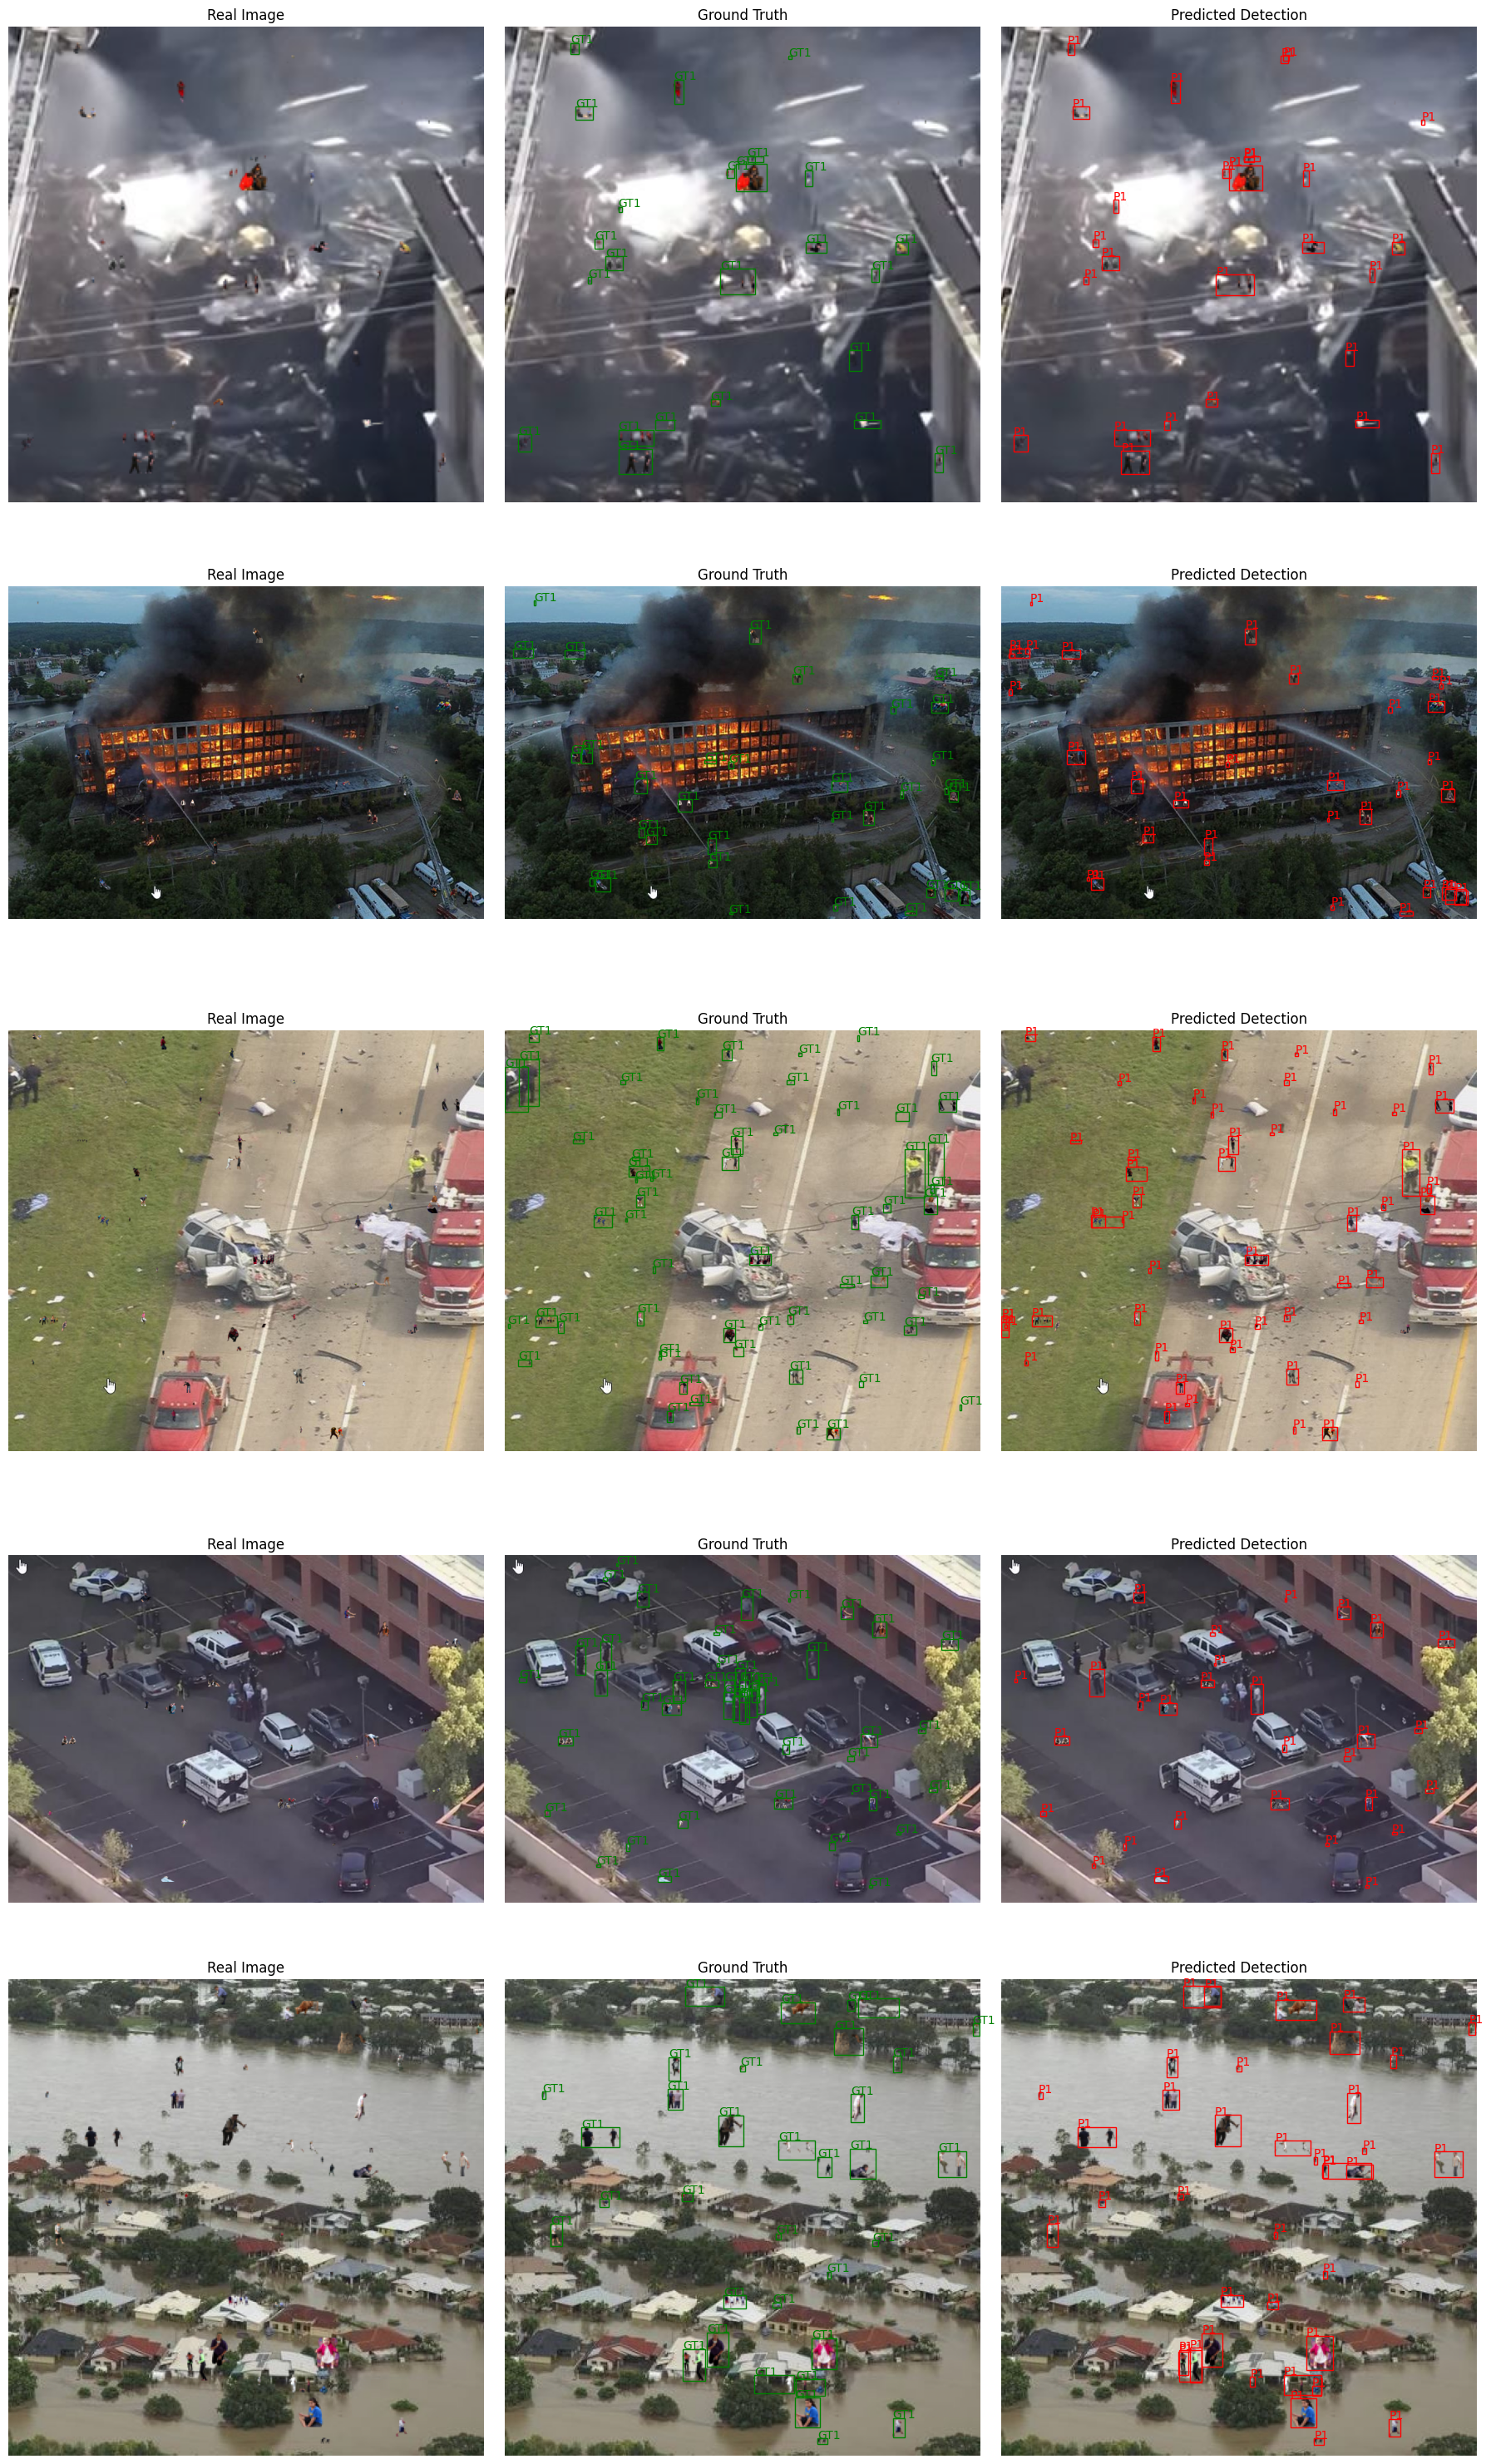

In [ ]:
# 7-------------------------------
# Visualization: Display 5 Random Validation Samples
# -------------------------------

import matplotlib.pyplot as plt         # For plotting images and figures.
import matplotlib.patches as patches     # For drawing rectangle patches (bounding boxes).
import numpy as np                       # For numerical operations.

# Set the number of random samples to visualize.
num_vis = 5

# Randomly sample 5 indices from the test_dataset (assumes test_dataset is defined).
indices = random.sample(range(len(test_dataset)), num_vis)

# Create a figure with 5 rows and 3 columns (for 3 panels per sample).
# The figure size is set to 18 inches in width and 6 * num_vis inches in height.
fig, axes = plt.subplots(nrows=num_vis, ncols=3, figsize=(18, 6 * num_vis))

# Define a helper function to draw bounding boxes on an axis.
def draw_boxes(ax, boxes, color, label_prefix):
    for i, box in enumerate(boxes):
        # Unpack the bounding box coordinates.
        x1, y1, x2, y2 = box
        # Calculate the width and height of the box.
        w, h = x2 - x1, y2 - y1
        # Create a rectangle patch with the calculated position and dimensions.
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)  # Add the rectangle patch to the axis.
        # Add a text label (e.g., GT1, GT2, etc. for ground truth or P1, P2, etc. for prediction) near the box.
        ax.text(x1, y1, f"{label_prefix}{i+1}", color=color, fontsize=10, backgroundcolor="none")

# Loop over each randomly selected sample index.
for idx_i, idx in enumerate(indices):
    # Get the image and target annotations from the test_dataset.
    image, target = test_dataset[idx]
    
    # -------------------------------
    # Denormalize the image for visualization.
    # -------------------------------
    # The applied transform normalized the image using ImageNet statistics.
    # To visualize, we reverse that normalization.
    image_np = image.clone()  # Clone the tensor to avoid modifying the original.
    # Multiply by the standard deviation and add the mean to reverse normalization.
    image_np = image_np * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib.
    image_np = image_np.permute(1, 2, 0).cpu().numpy()
    # Clip the values to ensure they are within the [0, 1] range.
    image_np = np.clip(image_np, 0, 1)
    
    # -------------------------------
    # Panel 1: Display the Real Image.
    # -------------------------------
    ax1 = axes[idx_i, 0]
    ax1.imshow(image_np)
    ax1.set_title("Real Image")
    ax1.axis("off")  # Hide axis ticks and labels.
    
    # -------------------------------
    # Panel 2: Display Ground Truth Bounding Boxes.
    # -------------------------------
    ax2 = axes[idx_i, 1]
    ax2.imshow(image_np)
    ax2.set_title("Ground Truth")
    ax2.axis("off")
    # Loop over each ground truth box and draw it in green.
    for box in target["boxes"]:
        draw_boxes(ax2, [box.cpu().numpy()], "g", "GT")
    
    # -------------------------------
    # Panel 3: Display Predicted Detections.
    # -------------------------------
    ax3 = axes[idx_i, 2]
    ax3.imshow(image_np)
    ax3.set_title("Predicted Detection")
    ax3.axis("off")
    # Run the model on the image to get predictions (move image to the correct device).
    with torch.no_grad():
        pred = model([image.to(device)])[0]
    # Filter predictions to keep only those with scores greater than 0.5.
    keep = pred['scores'] > 0.5
    pred_boxes = pred['boxes'][keep]
    # Loop over each predicted box and draw it in red.
    for box in pred_boxes:
        draw_boxes(ax3, [box.cpu().numpy()], "r", "P")
        
# Adjust the layout so that subplots do not overlap.
plt.tight_layout()
# Display the figure.
plt.show()


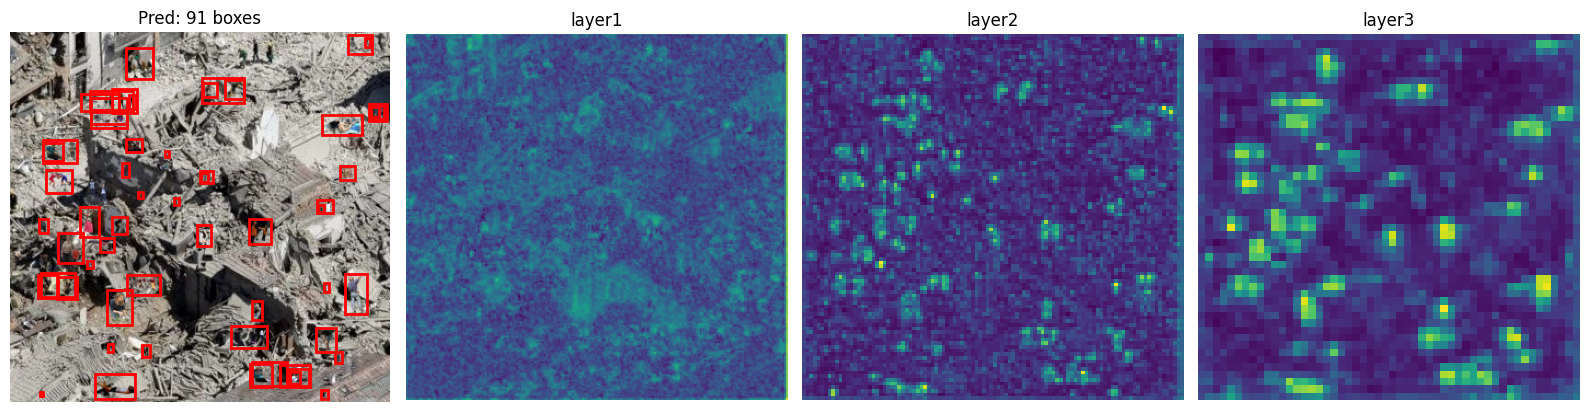

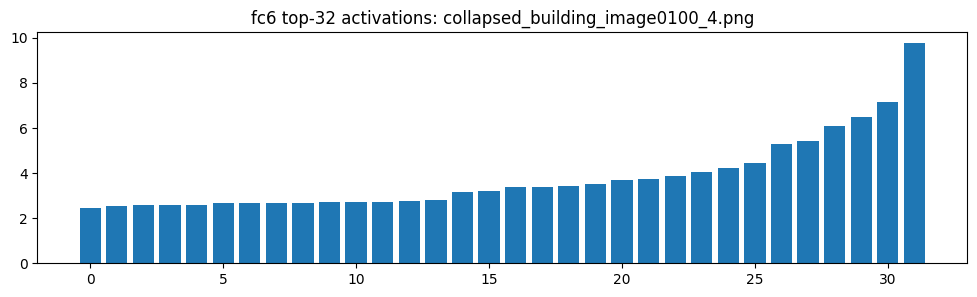

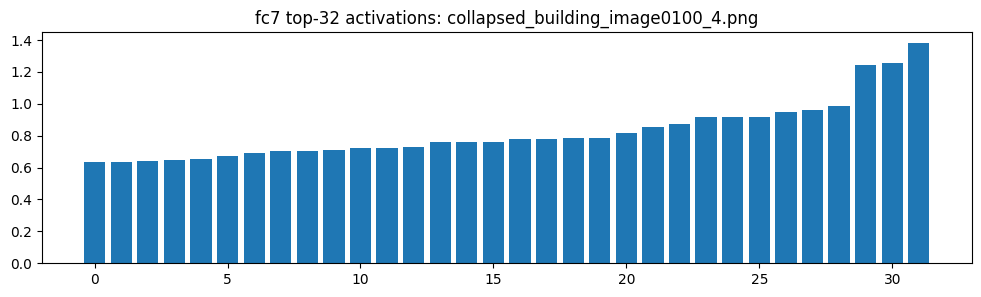

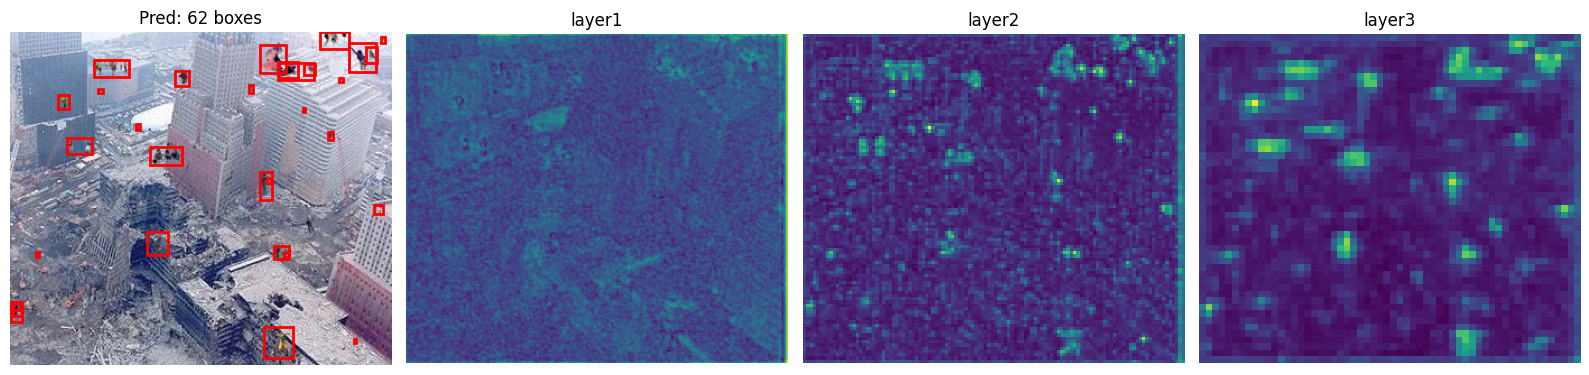

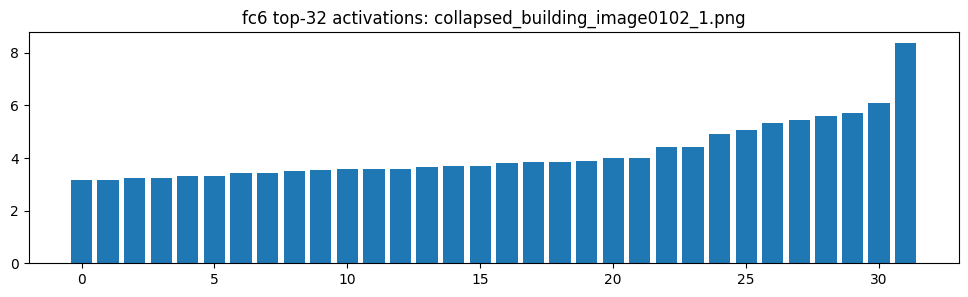

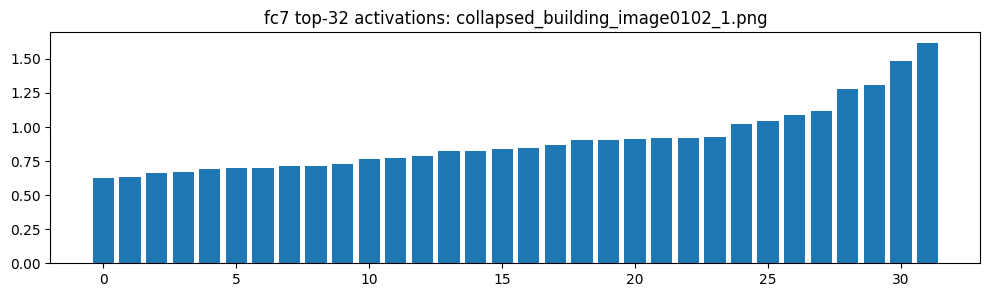

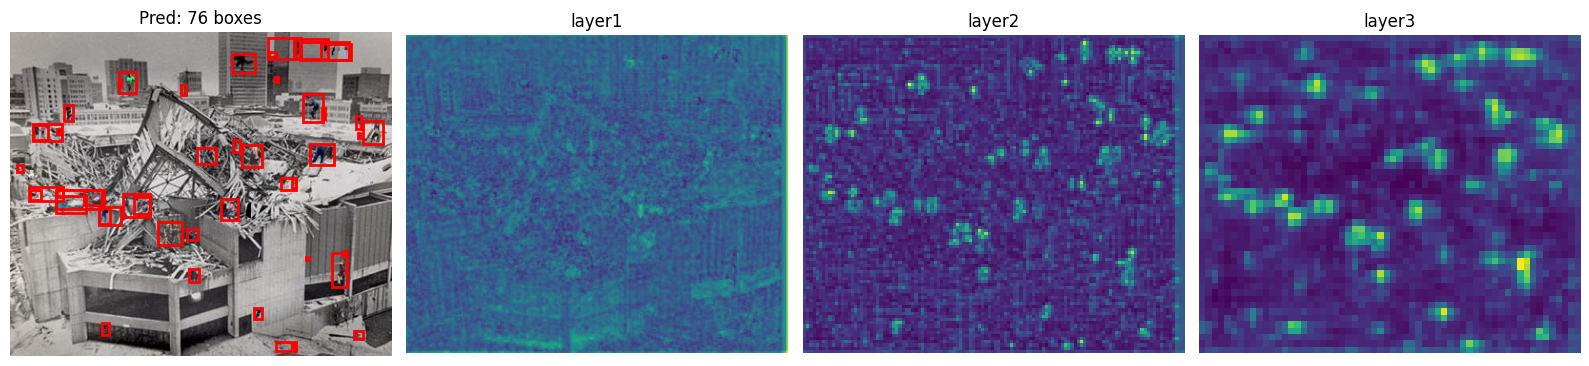

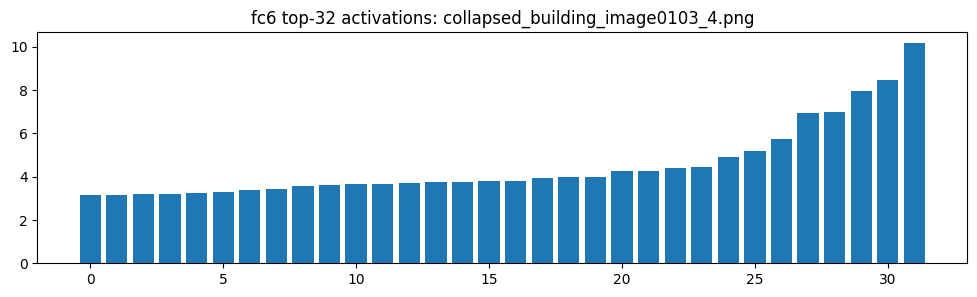

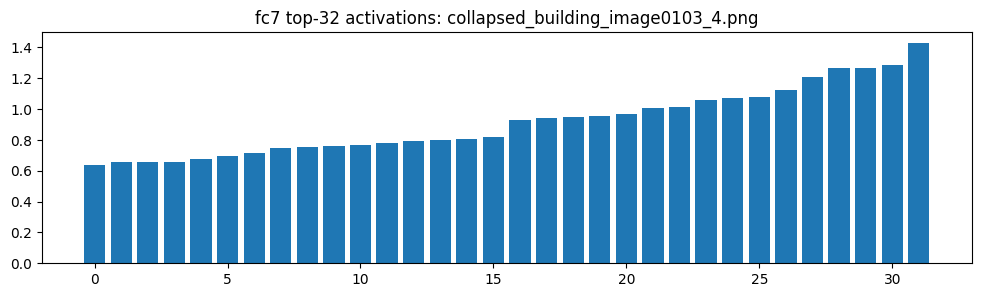

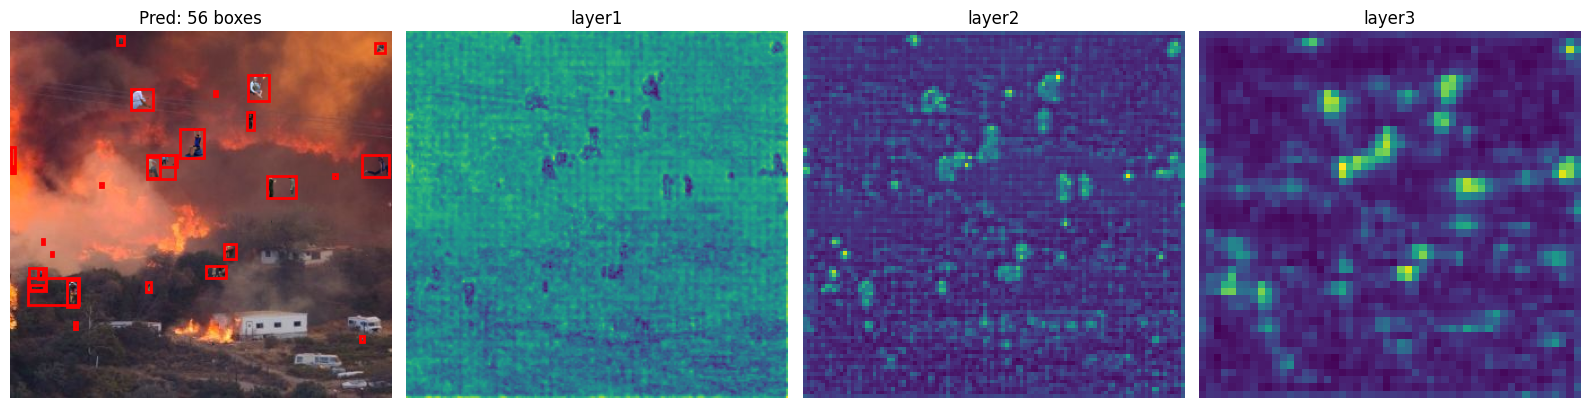

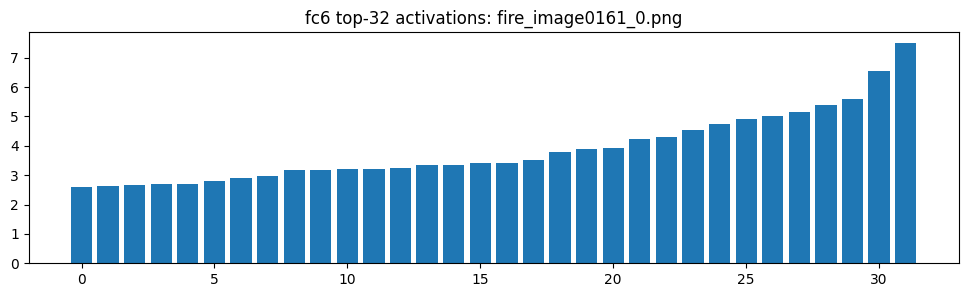

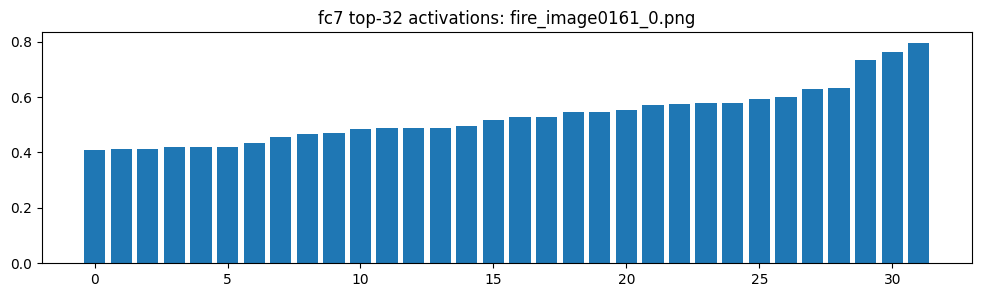

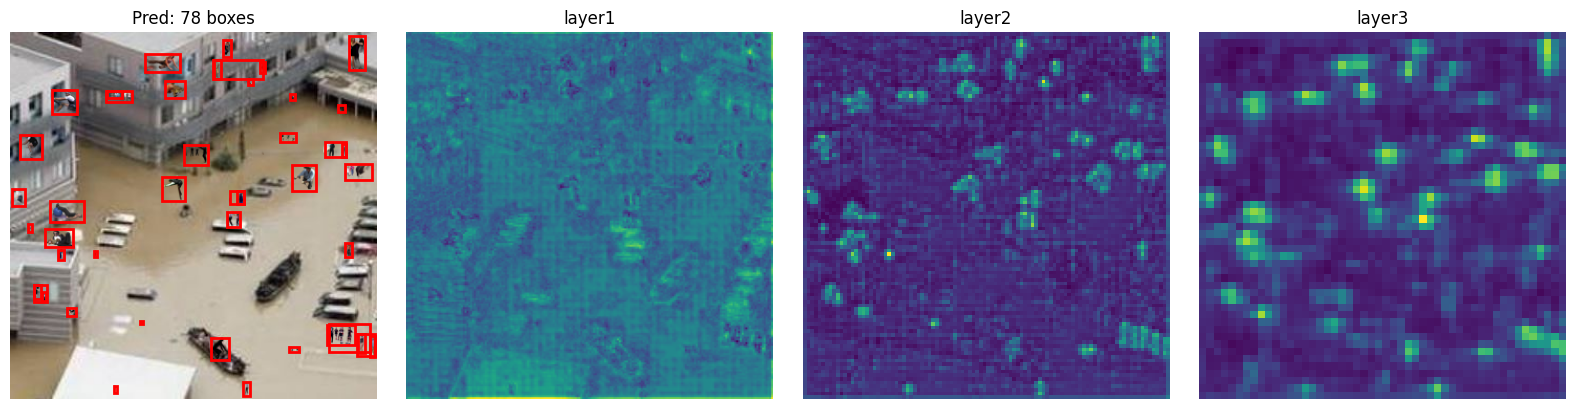

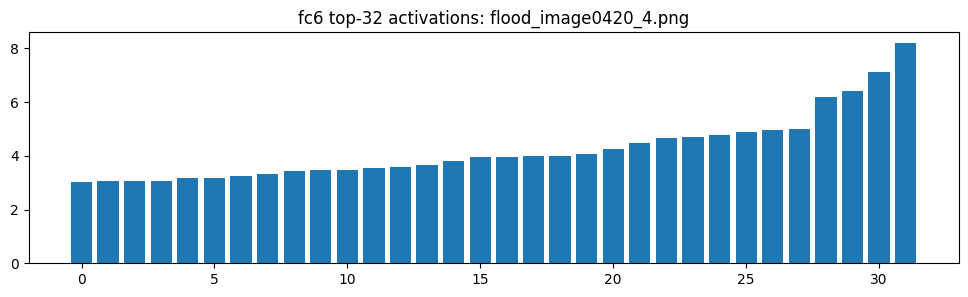

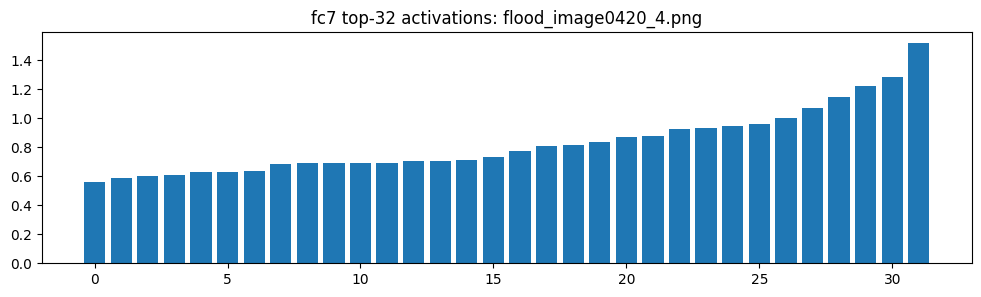

In [12]:
# Visualize feature maps (3 layers) and dense activations (2 layers) for 5 specified images
import matplotlib.pyplot as plt
import torchvision

# Hook storage
feature_maps = {}
dense_acts = {}

# Access backbone layers: for resnet50_fpn, use body.layer1/2/3
body = model.backbone.body

def save_fmap(name):
    def hook(module, inp, out):
        # Save mean over channels to reduce memory
        with torch.no_grad():
            fmap = out
            if isinstance(fmap, (list, tuple)):
                fmap = fmap[0]
            fmap_mean = fmap.detach().cpu().mean(dim=1, keepdim=True)  # [B,1,H,W]
            feature_maps[name] = fmap_mean
    return hook

# FC layers inside ROI heads: use box_head.fc6 and box_head.fc7

def save_dense(name):
    def hook(module, inp, out):
        with torch.no_grad():
            v = out.detach().cpu().flatten(1)  # [B, N]
            dense_acts[name] = v
    return hook

h1 = body.layer1.register_forward_hook(save_fmap('layer1'))
h2 = body.layer2.register_forward_hook(save_fmap('layer2'))
h3 = body.layer3.register_forward_hook(save_fmap('layer3'))
h_fc6 = model.roi_heads.box_head.fc6.register_forward_hook(save_dense('fc6'))
h_fc7 = model.roi_heads.box_head.fc7.register_forward_hook(save_dense('fc7'))

# Select 5 images
selected_dir = './C2A_selected'
selected_files = [
    'collapsed_building_image0100_4.png',
    'collapsed_building_image0102_1.png',
    'collapsed_building_image0103_4.png',
    'fire_image0161_0.png',
    'flood_image0420_4.png',
]

fig_idx = 1
for fname in selected_files:
    path = os.path.join(selected_dir, fname)
    img = Image.open(path).convert('RGB')
    img_t = transforms.ToTensor()(img).to(device)
    model.eval()
    with torch.no_grad():
        pred = model([img_t])[0]
    # Plot predictions overlay
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title(f'Pred: {len(pred["boxes"]) } boxes')
    ax = plt.gca()
    keep = pred['scores'] > 0.3
    for b in pred['boxes'][keep].cpu():
        x1,y1,x2,y2 = b.tolist()
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, color='r', linewidth=2)
        ax.add_patch(rect)
    plt.axis('off')
    # Trigger hooks by running backbone on a batch
    with torch.no_grad():
        _ = model([img_t])
    # Show 3 feature maps (mean over channels)
    for i, layer in enumerate(['layer1','layer2','layer3'], start=2):
        fmap = feature_maps.get(layer)
        if fmap is not None:
            fmap_np = fmap[0,0].numpy()
            plt.subplot(1,4,i)
            plt.imshow(fmap_np, cmap='viridis')
            plt.title(layer)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Dense activations bar plots
    for name in ['fc6','fc7']:
        v = dense_acts.get(name)
        if v is not None:
            v1 = v[0].numpy()
            top_idx = np.argsort(v1)[-32:]
            plt.figure(figsize=(12,3))
            plt.bar(range(32), v1[top_idx])
            plt.title(f'{name} top-32 activations: {fname}')
            plt.show()

# Remove hooks
h1.remove(); h2.remove(); h3.remove(); h_fc6.remove(); h_fc7.remove()

Scanning validation set for correct and incorrect samples (with progress bar)...


Grad-CAM search:  33%|███▎      | 668/2043 [00:27<00:56, 24.55it/s]


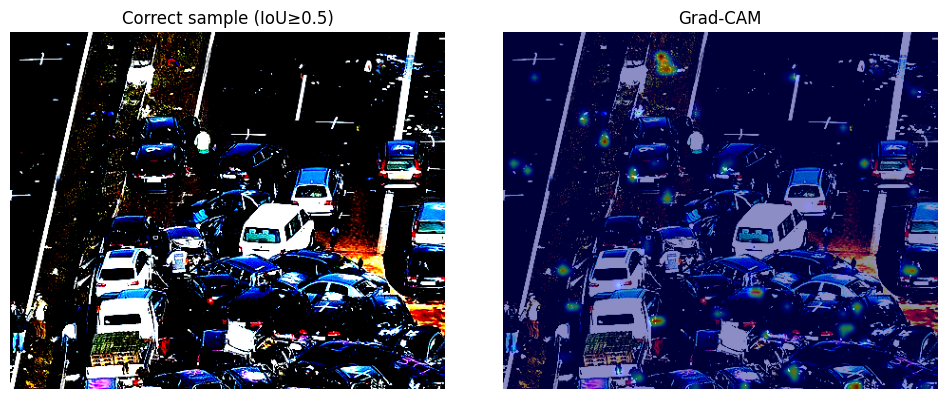

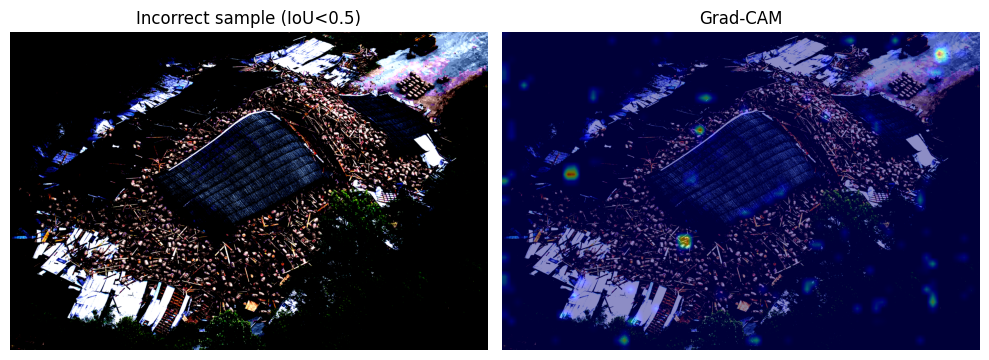

In [13]:
# Grad-CAM: dataset-driven correct vs incorrect visualization (with progress bar)
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.ops import box_iou

class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.layer = layer
        self.gradients = None
        self.activations = None
        self.h_forward = layer.register_forward_hook(self._forward_hook)
        self.h_backward = layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, image_t, score):
        self.model.zero_grad()
        score.backward(retain_graph=True)
        grads = self.gradients.detach()
        acts = self.activations.detach()
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam[0,0]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        return cam.cpu().numpy()

    def remove(self):
        self.h_forward.remove(); self.h_backward.remove()

# helper overlay
def show_cam_on_image(img_tensor, cam_map, title='Grad-CAM'):
    img_np = img_tensor.detach().cpu().permute(1,2,0).numpy()
    img_np = np.clip(img_np, 0, 1)
    if cam_map.shape[:2] != img_np.shape[:2]:
        import cv2
        cam_map = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.title(title); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_np); plt.imshow(cam_map, cmap='jet', alpha=0.45); plt.title('Grad-CAM'); plt.axis('off')
    plt.tight_layout(); plt.show()

model.eval()
cam_layer = model.backbone.body.layer3
cam = GradCAM(model, cam_layer)

found_correct = False
found_incorrect = False
correct_image = None
incorrect_image = None

print('Scanning validation set for correct and incorrect samples (with progress bar)...')
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc='Grad-CAM search', leave=True):
        image = images[0].to(device)
        t = {k:v.to(device) for k,v in targets[0].items()}
        out = model([image])[0]
        keep = out['scores'] > 0.3
        pb = out['boxes'][keep]
        ious = box_iou(pb, t['boxes']) if len(t['boxes'])>0 and len(pb)>0 else torch.zeros((len(pb),0), device=pb.device)
        max_iou = ious.max().item() if ious.numel()>0 else 0.0
        if max_iou >= 0.5 and not found_correct:
            correct_image = image
            found_correct = True
        if (len(pb)==0 or max_iou < 0.5) and not found_incorrect:
            incorrect_image = image
            found_incorrect = True
        if found_correct and found_incorrect:
            break

# Compute Grad-CAMs
if correct_image is not None:
    img = correct_image.clone().requires_grad_(True)
    out = model([img])[0]
    idx = torch.argmax(out['scores']) if len(out['scores'])>0 else None
    if idx is not None:
        score = out['scores'][idx]
        cam_map = cam.generate(img, score)
        show_cam_on_image(img, cam_map, title='Correct sample (IoU≥0.5)')
    else:
        print('Correct sample found but produced no detections on gradient pass.')
else:
    print('No correct sample found (IoU≥0.5).')

if incorrect_image is not None:
    img = incorrect_image.clone().requires_grad_(True)
    out = model([img])[0]
    idx = torch.argmax(out['scores']) if len(out['scores'])>0 else None
    if idx is not None:
        score = out['scores'][idx]
        cam_map = cam.generate(img, score)
        show_cam_on_image(img, cam_map, title='Incorrect sample (IoU<0.5)')
    else:
        print('Incorrect sample has no detections; cannot backpropagate score.')
else:
    print('No incorrect sample found (IoU<0.5).')

cam.remove()

Building PR and F1 curves on the validation set...


C:\Users\PC\AppData\Local\Temp\ipykernel_33904\1257837501.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  approx_ap = float(np.trapz(precisions, recalls))
C:\Users\PC\AppData\Local\Temp\ipykernel_33904\1257837501.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  approx_ap = float(np.trapz(precisions, recalls))


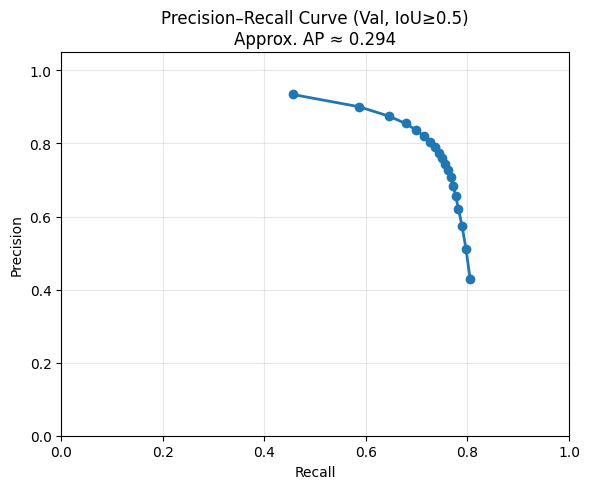

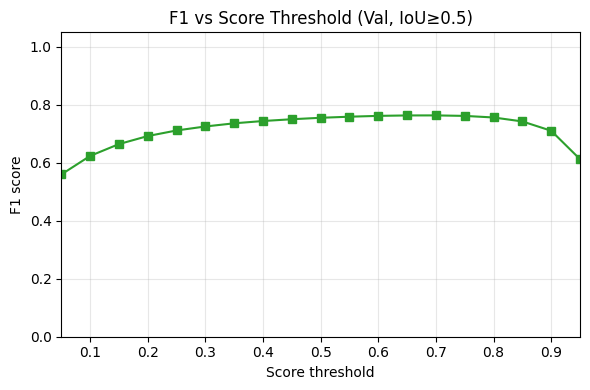

Note: Line graphs are ideal for trends; PR curve and F1-vs-threshold are standard for detection.
If you log per-epoch histories (loss, mAP), we can add classic epoch-wise line charts too.


In [11]:
# 9️⃣ Line-style performance plots: PR curve and F1 vs threshold
# These plots show typical line graphs used for performance visualization without retraining.
# - Precision–Recall (PR) curve on the validation set (IoU>=0.5)
# - F1 vs score threshold curve

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.ops import box_iou


def compute_counts_at_threshold(model, loader, device, score_threshold=0.5, iou_threshold=0.5, max_batches=None):
    """Accumulate TP/FP/FN over the dataset at a fixed score threshold."""
    TP = FP = FN = 0
    with torch.no_grad():
        for b_idx, (images, targets) in enumerate(tqdm(loader, desc=f'@thr={score_threshold:.2f}', leave=False)):
            # single-image batches assumed; extend easily if batch>1 by looping
            image = images[0].to(device)
            target = {k: v.to(device) for k, v in targets[0].items()}
            out = model([image])[0]
            keep = out['scores'] >= score_threshold
            pred_boxes = out['boxes'][keep]
            gt_boxes = target['boxes'] if 'boxes' in target else torch.empty((0,4), device=device)

            if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                # nothing present in either → no counts
                pass
            elif len(pred_boxes) == 0 and len(gt_boxes) > 0:
                FN += len(gt_boxes)
            elif len(pred_boxes) > 0 and len(gt_boxes) == 0:
                FP += len(pred_boxes)
            else:
                ious = box_iou(pred_boxes, gt_boxes)
                # Greedy matching by IoU
                matched_gt = set()
                for i in range(ious.shape[0]):
                    max_iou, j = ious[i].max(0)
                    j = j.item()
                    if max_iou.item() >= iou_threshold and j not in matched_gt:
                        TP += 1
                        matched_gt.add(j)
                    else:
                        FP += 1
                FN += (ious.shape[1] - len(matched_gt))

            if max_batches is not None and (b_idx + 1) >= max_batches:
                break
    return TP, FP, FN


def pr_curve(model, loader, device, thresholds=None, iou_threshold=0.5, max_batches=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    precisions, recalls, f1s = [], [], []
    for thr in thresholds:
        TP, FP, FN = compute_counts_at_threshold(model, loader, device, float(thr), iou_threshold, max_batches)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    # Sort by recall for a nicer PR plot
    recalls = np.array(recalls)
    precisions = np.array(precisions)
    f1s = np.array(f1s)
    order = np.argsort(recalls)
    return recalls[order], precisions[order], f1s[order], np.array(thresholds)[order]


# Ensure model is loaded (we rely on the previous cell that may have loaded best checkpoint)
model.eval()

print('Building PR and F1 curves on the validation set...')
recalls, precisions, f1s, thr_sorted = pr_curve(model, val_loader, device, iou_threshold=0.5)

# Compute a simple AP approximation via trapezoidal rule on P(R)
approx_ap = 0.0
if len(recalls) > 1:
    approx_ap = float(np.trapz(precisions, recalls))

# Plot PR curve (line graph)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, marker='o', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve (Val, IoU≥0.5)\nApprox. AP ≈ {approx_ap:.3f}')
plt.xlim(0, 1.0)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot F1 vs threshold (line graph)
plt.figure(figsize=(6,4))
plt.plot(thr_sorted, f1s, marker='s', color='tab:green')
plt.xlabel('Score threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Score Threshold (Val, IoU≥0.5)')
plt.xlim(thr_sorted.min(), thr_sorted.max())
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Note: Line graphs are ideal for trends; PR curve and F1-vs-threshold are standard for detection.\nIf you log per-epoch histories (loss, mAP), we can add classic epoch-wise line charts too.')